In [103]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Stuff important to Naive Bayes specifically
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

## Last pre-processing

Rename the columns as well as change positive tweets from target = 4 to target = 1

In [2]:
df = pd.read_csv("../tweets-cleaned.csv", encoding='ISO-8859-1')
df = df.iloc[:, [0, 2]] # Don't want the data from before processing
df

,target,clean
0,0,URL aww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see
...,...,...
1599995,4,woke school best feeling ever
1599996,4,URL cool hear old walt interview URL
1599997,4,ready mojo makeover URL detail
1599998,4,happy th birthday boo all time tupac amaru shakur


In [3]:
df['target'].replace(4, 1, inplace=True) # Replace all the 4s with 1s
df.rename(columns={'target': 'sentiment', 'text':'tweet'}, inplace=True) # Rename the columns
df

,sentiment,clean
0,0,URL aww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see
...,...,...
1599995,1,woke school best feeling ever
1599996,1,URL cool hear old walt interview URL
1599997,1,ready mojo makeover URL detail
1599998,1,happy th birthday boo all time tupac amaru shakur


In [4]:
df.dtypes

sentiment     int64
clean        object
dtype: object

In [5]:
text, sentiment = list(df['clean']), list(df['sentiment']) # Turn these both into lists

text = [str(item) for item in text]
positive_text = text[800000:] # Dataset arranged in a way such that the first half is negative and second half is positive
negative_text = text[:800000]
negative_text[0].split()

['URL', 'aww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']

## Word cloud for positive and negative text

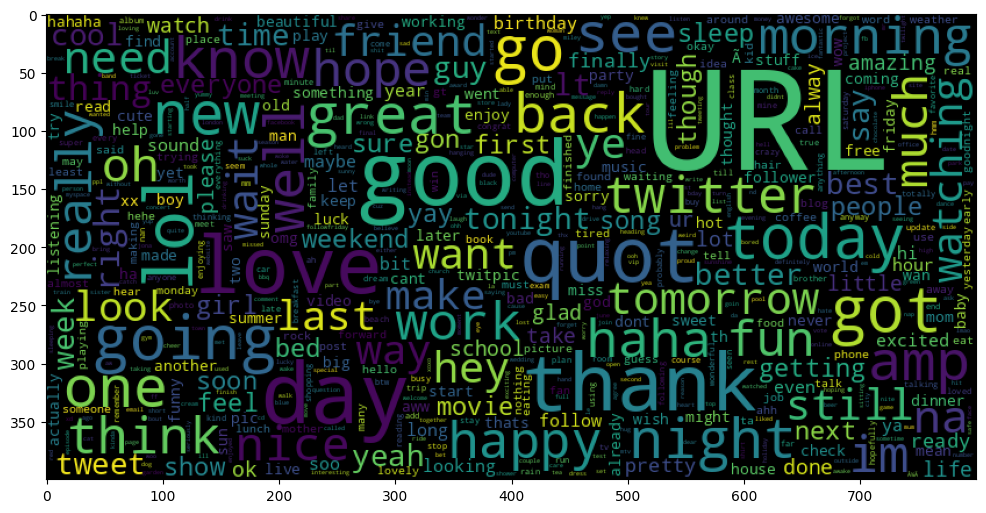

In [6]:
# Positive text
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(positive_text))
plt.imshow(wc)

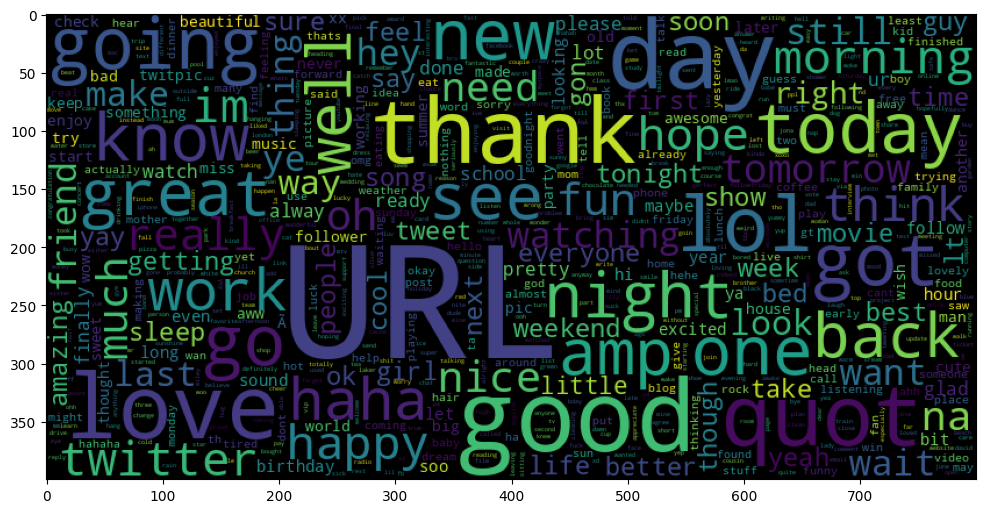

In [7]:
# Negative text
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(positive_text))
plt.imshow(wc)

In [7]:
with open("../stop-words.txt") as f:
    stopwords = [line.strip() for line in f]
stopwords = set(stopwords)
stopwords # Check the stop words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Naive Bayes

Implement Naive Bayes from scratch BUT also consider bigrams

In [74]:
class NaiveBayesClassifier:
    def __init__(self):
        self.vocab = set()  # Vocabulary
        with open("../stop-words.txt") as f:
            self.stopwords = [line.strip() for line in f]
        self.stopwords = set(self.stopwords) # Set of stop words to check against

        self.negative_word_count = 0 # Total number of words for each class
        self.positive_word_count = 0
        self.positive_words = {}  # Word frequencies for each class
        self.negative_words = {}

        self.positive_bigram_count = 0
        self.negative_bigram_count = 0
        self.positive_bigrams = {}
        self.negative_bigrams = {}

    def clean(self, text):        
        # Convert to lowercase
        message = text.lower()
        # Remove URLs. Match words that begin with http, http\S+, www, etc... and \S+ which is just one or more non-whitespace characters
        message = re.sub(r'\shttp\S+|\swww\S+|\shttps\S+', ' URL ', message, flags=re.MULTILINE)

        # Do they same as above but match with anything that ends with .com, .net, or website endings
        message = re.sub(r'\S+.com\s|\S+.net\s|\S+.org\s|\S+.co\s|\S+.us\s|\S+.edu\s|\S+.me\s|\S+.cn\s|\S+.uk\s|\S+.cn\s', ' URL ', message, flags=re.MULTILINE)
        # Get rid of @ mentions from the tweet dataset
        message = re.sub(r'@\S+', '', message, flags=re.MULTILINE)

        # Remove punctuation
        message = re.sub(r'\W', ' ', message)
        # Remove digits
        message = re.sub(r'\d+', '', message)

        # Tokenize the tweet (just store each word into a list)
        tokens = word_tokenize(message)

        tokens = [token for token in tokens if token not in stopwords] # Keep the ones that aren't a stop word

        # Lemmatize tokens, converting it back to its base form
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        tokens = [token for token in tokens if len(token) > 1] # Get rid of random letters out and about from punctuation removal
        return tokens # Return a list of tokens

    def fit(self, positive_text, negative_text):
        for i in range(len(positive_text)):
            splitted = positive_text[i].split()
            for j in range(len(splitted)):
                if splitted[j] not in self.positive_words: # Keep track of 
                    self.positive_words[splitted[j]] = 0
                self.positive_words[splitted[j]] += 1
                self.positive_word_count += 1

                if j < len(splitted) - 1: # We can count bigrams
                    self.positive_bigram_count += 1
                    curr = splitted[j] + splitted[j+1]
                    if curr not in self.positive_bigrams:
                        self.positive_bigrams[curr] = 0
                    self.positive_bigrams[curr] += 1

        for i in range(len(negative_text)):
            splitted = negative_text[i].split()
            for j in range(len(splitted)):
                if splitted[j] not in self.negative_words:
                    self.negative_words[splitted[j]] = 0
                self.negative_words[splitted[j]] += 1
                self.negative_word_count += 1

                if j < len(splitted) - 1: # We can count bigrams
                    self.negative_bigram_count += 1
                    curr = splitted[j] + splitted[j+1]
                    if curr not in self.negative_bigrams:
                        self.negative_bigrams[curr] = 0
                    self.negative_bigrams[curr] += 1
    
    def predict(self, text): # VERY similar to data preprocessing, 1. Preprocess 2. Run inference based off the words
        tokens = self.clean(text) # Clean the message and get tokens in the form that we want
        pos_word_prob = 1
        neg_word_prob = 1
        pos_bigram_prob = 1
        neg_bigram_prob = 1
        for i in range(len(tokens)):
            if tokens[i] in self.positive_words and tokens[i] in self.negative_words: # Calculate these only if they're in both, otherwise one will get scaled down too much
                pos_word_prob *= self.positive_words[tokens[i]] / self.positive_word_count
                neg_word_prob *= self.negative_words[tokens[i]] / self.negative_word_count

            if i < len(tokens)-1:
                curr = tokens[i] + tokens[i+1]
                if curr in self.positive_bigrams and curr in self.negative_bigrams:
                    pos_bigram_prob *= self.positive_bigrams[curr] / self.positive_bigram_count
                    neg_bigram_prob *= self.negative_bigrams[curr] / self.negative_bigram_count
        final_pos = pos_bigram_prob + pos_word_prob
        final_neg = neg_bigram_prob + neg_word_prob 
        if final_pos > final_neg:
            return 1
        else:
            return 0    

In [82]:
import random
random.shuffle(positive_text)
random.shuffle(negative_text)
train_pos = positive_text[:700000]
train_neg = negative_text[:700000]

test_pos = positive_text[700000:]
test_neg = negative_text[700000:]

In [83]:
Naive_Bayes = NaiveBayesClassifier()
Naive_Bayes.fit(train_pos, train_neg)
print("Training complete.")

Training complete.


In [91]:
message = "wow yourself"
Naive_Bayes.predict(message)

1

## Test for validation
Test the dataset to see how accurate it is

In [85]:
correct_count = 0
for i in range(len(test_pos)):
    if Naive_Bayes.predict(test_pos[i]) == 1:
        correct_count += 1
for i in range(len(test_neg)):
    if Naive_Bayes.predict(test_neg[i]) == 0:
        correct_count += 1
print("Overall accuracy on validation set:", correct_count/(len(test_pos) + len(test_neg)))

Overall accuracy on validation set: 0.7264


## Try with Multinomial Naive Bayes and Logistic Regression

In [105]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.2, random_state=42) # Get a train test split based off of Naive Bayes

In [106]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [107]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.78      0.77      0.77    159494
           1       0.77      0.78      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



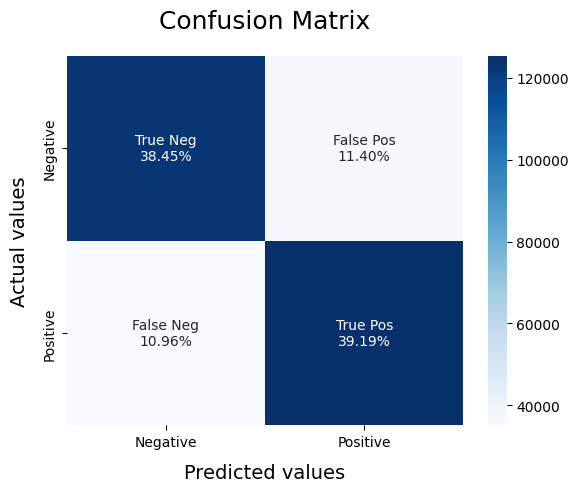

In [108]:
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)
model_Evaluate(MultiNB)

              precision    recall  f1-score   support

           0       0.80      0.77      0.79    159494
           1       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



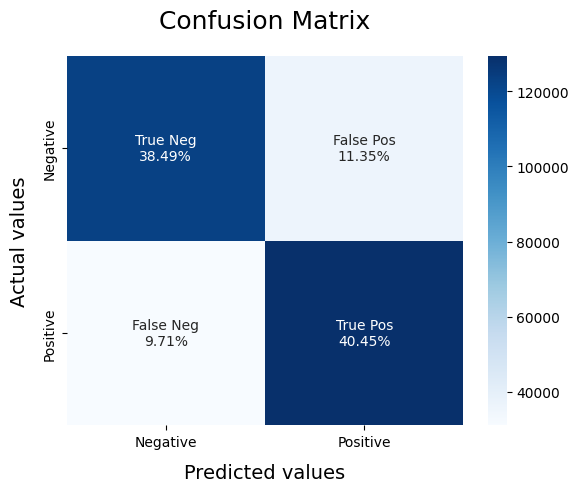

In [109]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)